In [80]:
# As instructed all code is taken and modified from here: 
# https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [82]:
df = pd.read_csv("C:\\Users\\rjgle\\Documents\\CSCE 587\\Homework3\\airfoil_self_noise.txt", delimiter="\t")
df.head()

,freq,angle,length,velocity,thickness,pressureLevel
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [83]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [84]:
# Train - Test
# Stratify had to be removed as attempting to use it with a
# test_size of 0.2 like instructed caused and error
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [85]:
# Split train into train-val
# Again stratify is removed
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

In [86]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [87]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_out = nn.Linear(10, 1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return (x)

In [88]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [89]:
EPOCHS = 2000
BATCH_SIZE = 64
LEARNING_RATE = 0.05
NUM_FEATURES = len(X.columns)

In [90]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [92]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=5, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [93]:
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()

            
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list] 
            
mse = mean_absolute_error(y_test, y_pred_list)
mse

  0%|          | 0/2000 [00:00<?, ?it/s]

2.8555972221095693

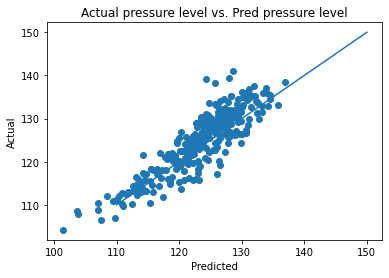

In [94]:
plt.scatter(y_pred_list, y_test)
plt.title("Actual pressure level vs. Pred pressure level")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.plot([110,130,150],[110,130,150])
plt.show()